Data Science Regression Project: Predicting Home Prices in Banglore

In [212]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20,10)

Data Load: Load banglore home prices into a dataframe

In [213]:
df1 = pd.read_csv('bengaluru_house_prices.csv')
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [214]:
df1.shape

(13320, 9)

In [215]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

Drop features that are not required to build our model

In [216]:
df2 = df1.drop(['area_type', 'society', 'balcony', 'availability' ], axis='columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


Data Cleaning: Handle NA values

In [217]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [218]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [219]:
df3.shape

(13246, 5)

In [220]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

Feature Engineering

Add new feature(integer) for bhk (Bedrooms Hall Kitchen)


In [221]:
df3['bhk'] = df3['size'].apply(lambda x: int (x.split(' ')[0]))

C:\Users\hp\AppData\Local\Temp\ipykernel_4680\3136401136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int (x.split(' ')[0]))


In [222]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [223]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [224]:
df3['bhk'].dtype


dtype('int64')

In [225]:
df3[df3.bhk > 20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [226]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      shape=(2067,), dtype=object)

Explore total_sqft feature

In [227]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [228]:
df3[~df3['total_sqft'].apply(is_float)].head()

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2



Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [229]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [230]:
convert_sqft_to_num('2166')

2166.0

In [231]:
convert_sqft_to_num('2100 - 2050')

2075.0

In [232]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850

In [233]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [234]:
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


Feature Engineering

Add new feature called price per square feet

In [235]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [236]:
len(df5.location.unique())

1304

Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [237]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

location
Whitefield                              535
Sarjapur  Road                          392
Electronic City                         304
Kanakpura Road                          266
Thanisandra                             236
                                       ... 
Duddanahalli                              1
Doddanakunte                              1
Jogupalya                                 1
Subhash Nagar                             1
Kengeri Satellite Town KHB Apartment      1
Name: count, Length: 1293, dtype: int64

In [238]:
len(location_stats[location_stats<=10])

1052


Dimensionality Reduction

Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [239]:
location_stats_less_than_10 = len(location_stats[location_stats<=10])

location_stats_less_than_10 = location_stats[location_stats <= 10].index.tolist()


In [240]:
len(df5.location.unique())

1293

In [241]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

242

In [242]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


Outlier Removal Using Business Logic

As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [243]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [244]:
df5.shape

(13246, 7)

Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [245]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12502, 7)

Outlier Removal Using Standard Deviation and Mean


In [246]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [247]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape


(10241, 7)

Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

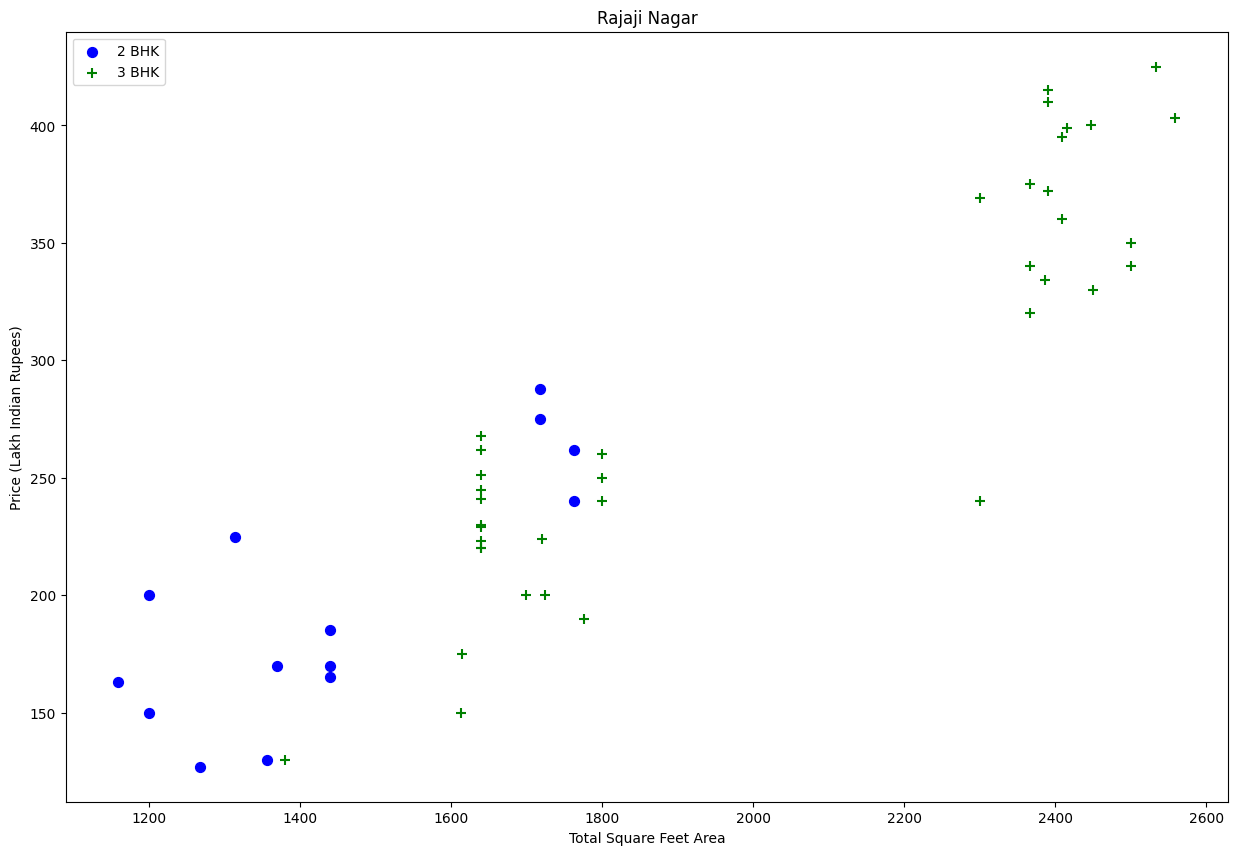

In [248]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

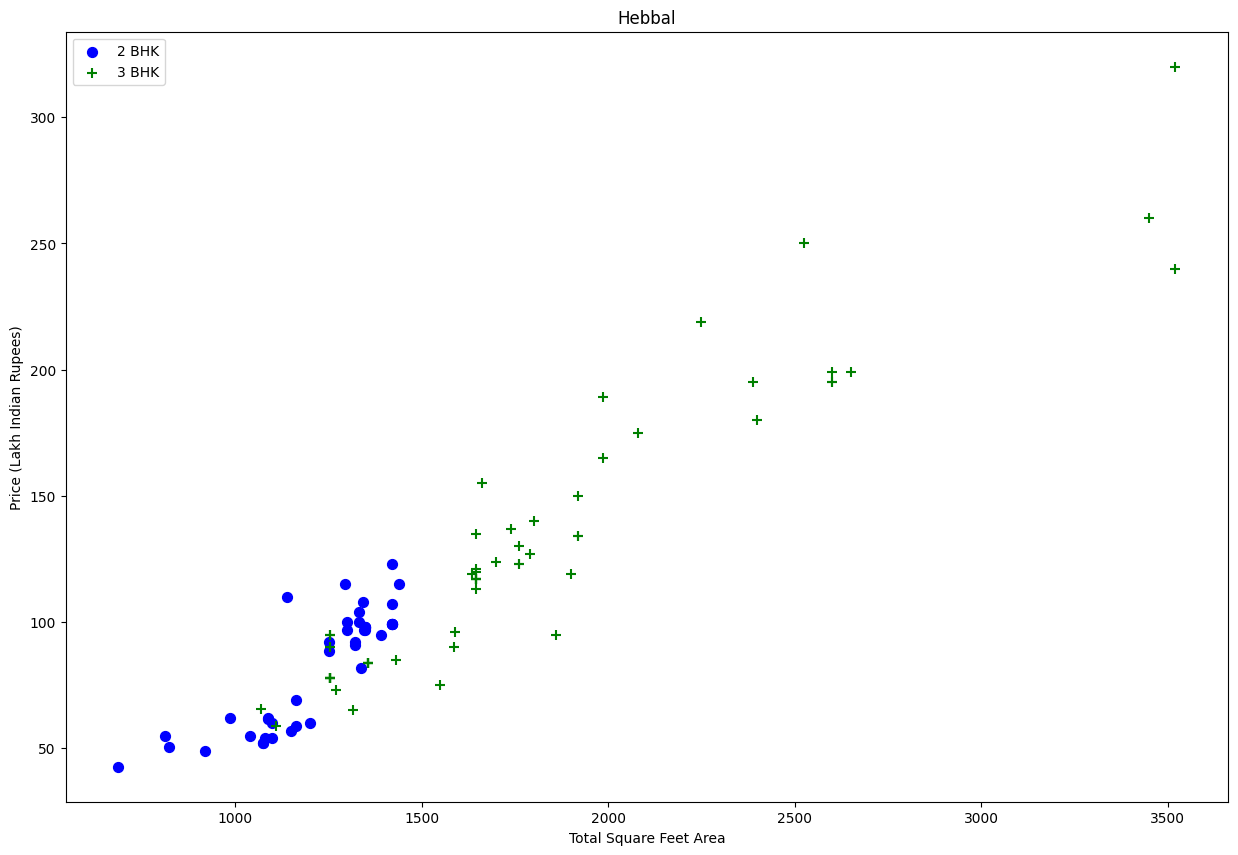

In [249]:
plot_scatter_chart(df7,"Hebbal")

We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.

{

    '1' : {

        'mean': 4000,
        'std: 2000,
        'count': 34

    },

    '2' : {

        'mean': 4300,
        'std: 2300,
        'count': 22

    },    
    
}

Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [250]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape


(7329, 7)

Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties

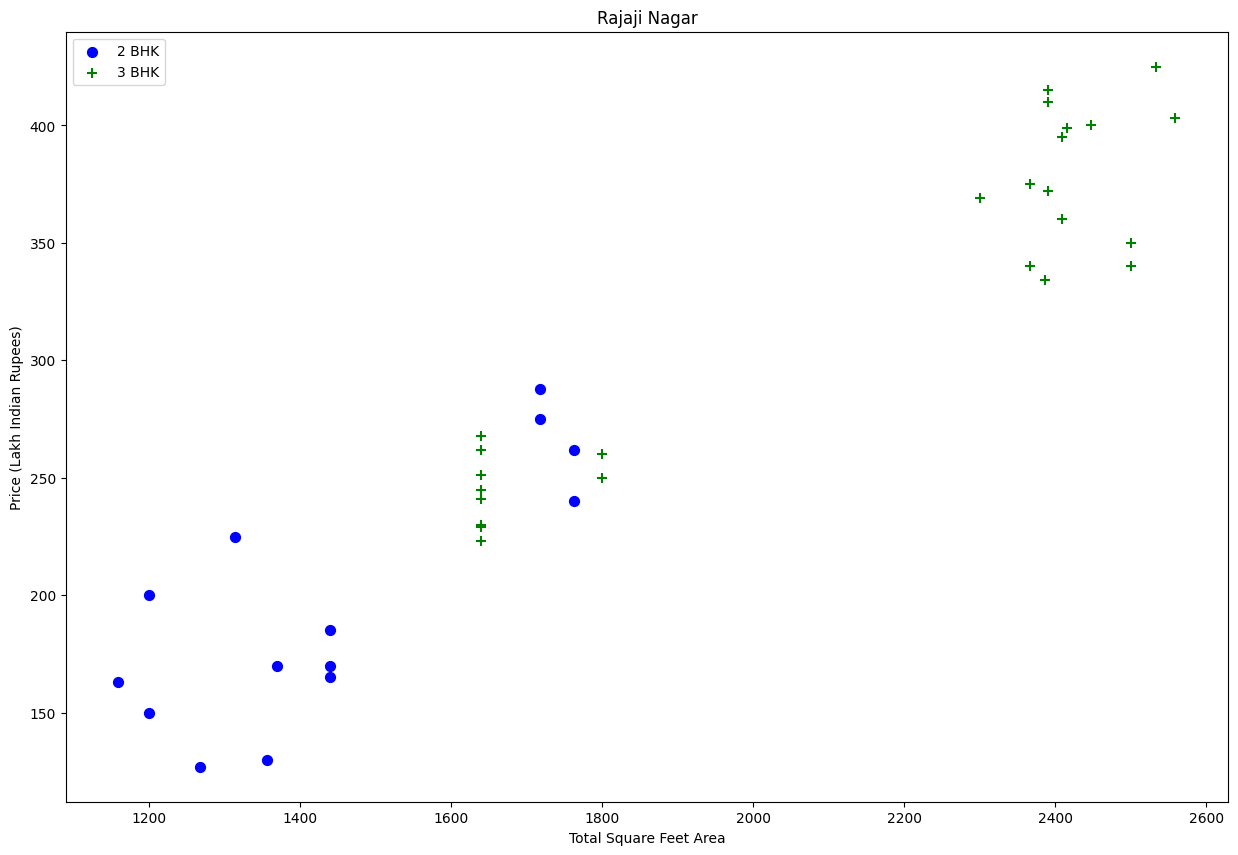

In [251]:
plot_scatter_chart(df8,"Rajaji Nagar")

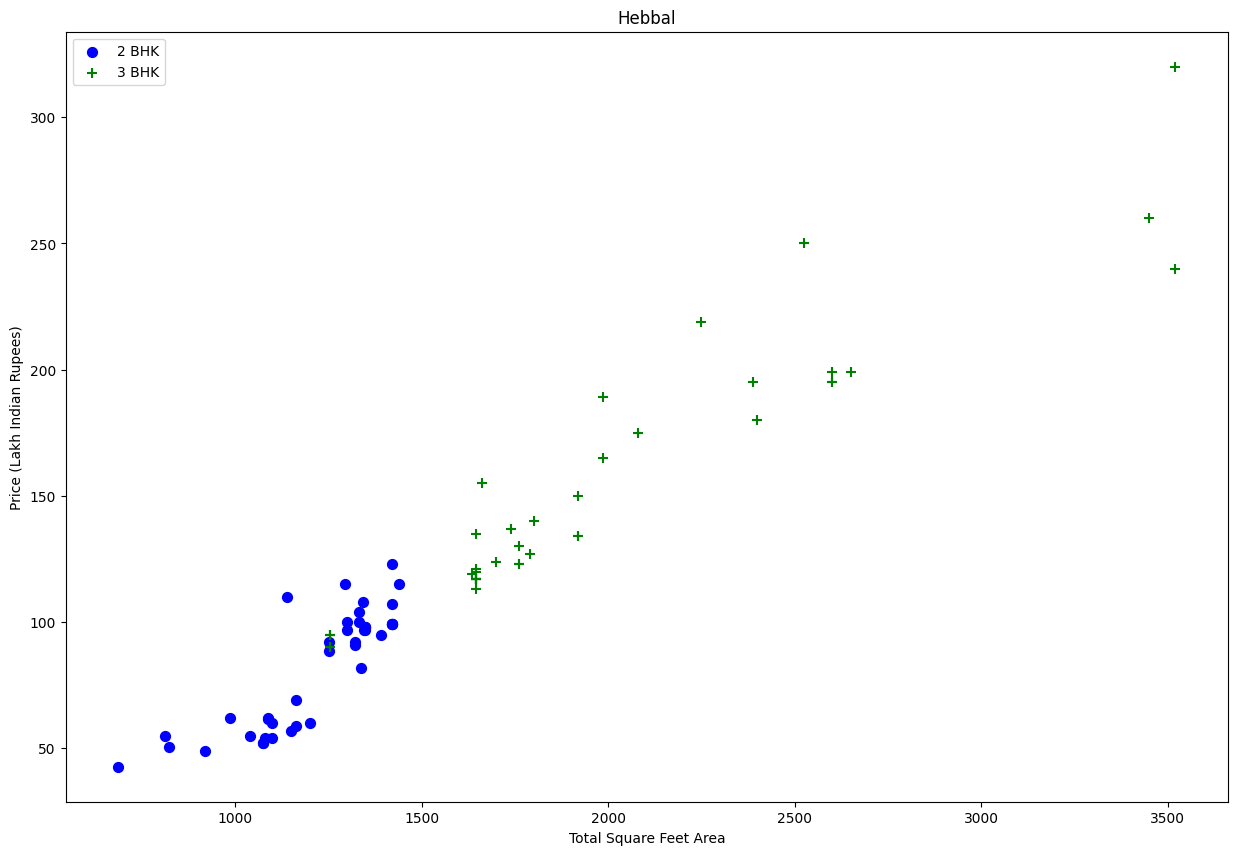

In [252]:
plot_scatter_chart(df8,"Hebbal")

Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function

Text(0, 0.5, 'Count')

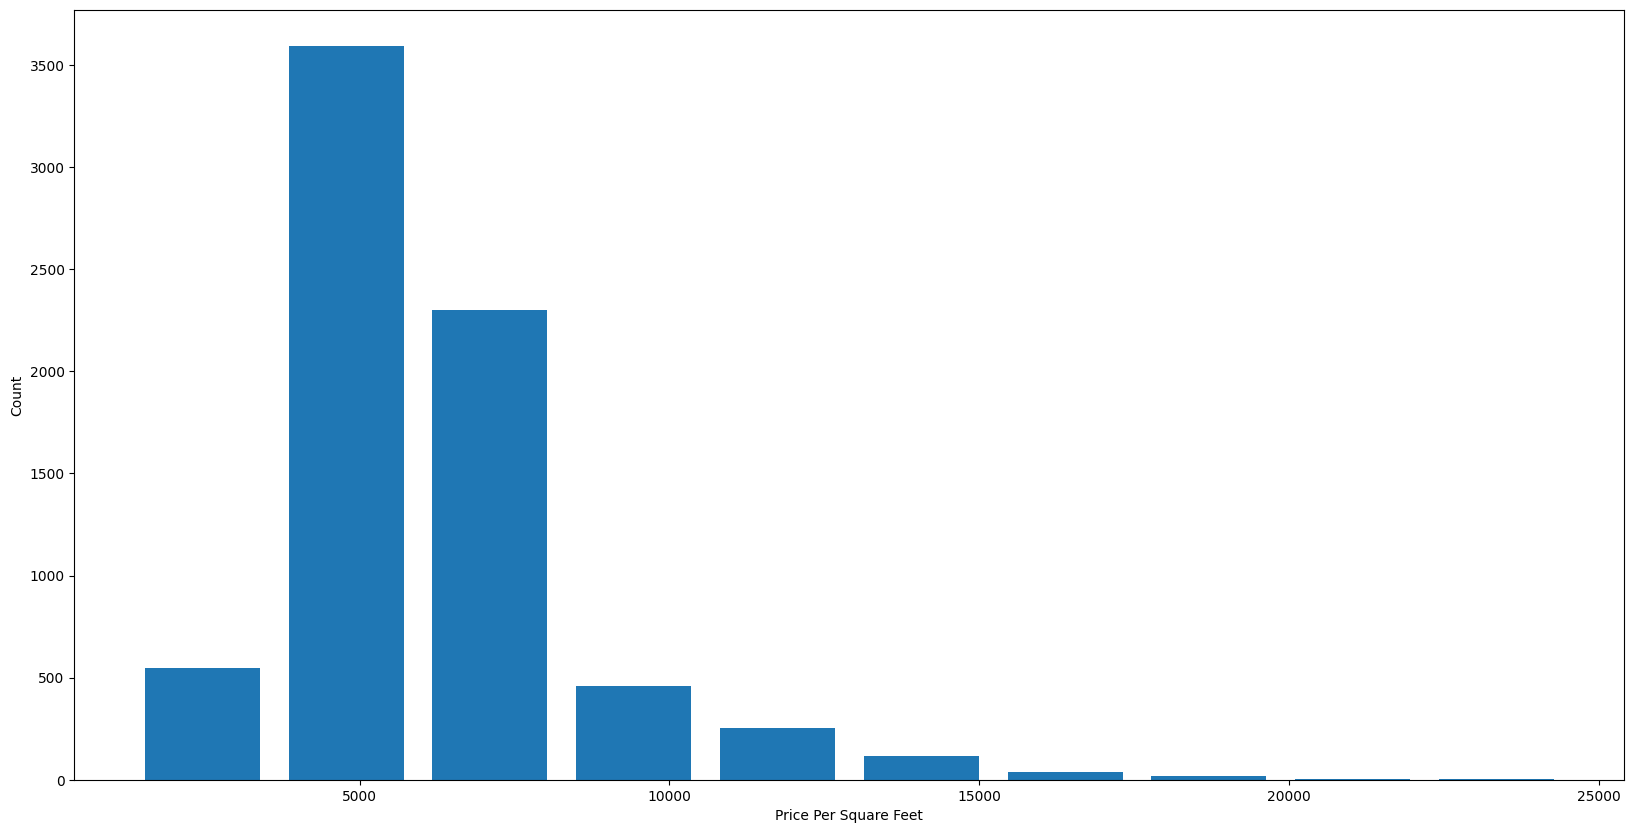

In [253]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")


Outlier Removal Using Bathrooms Feature


In [254]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

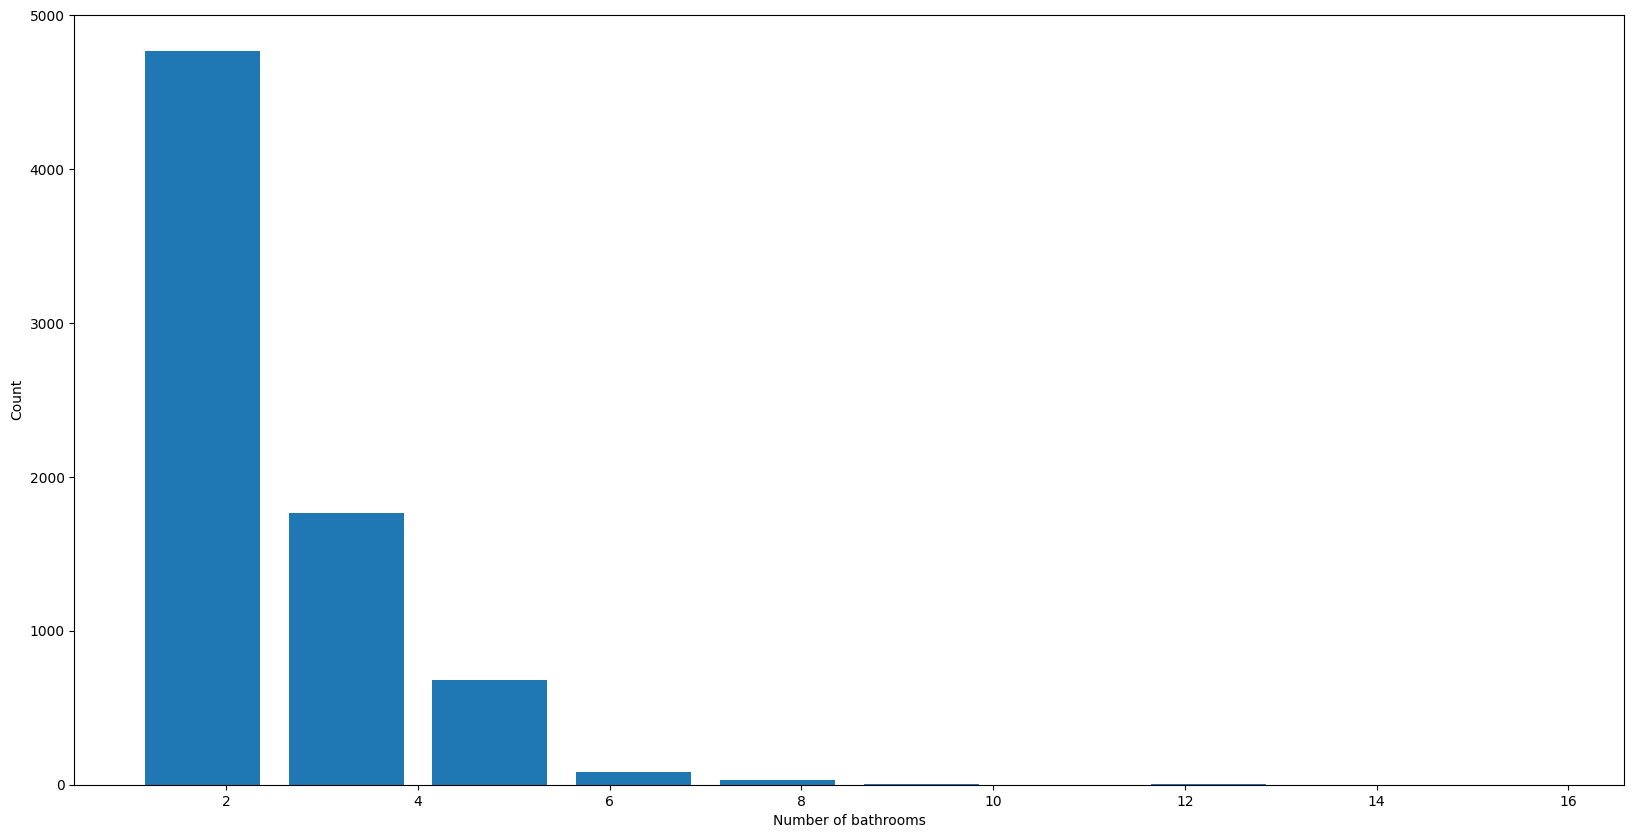

In [255]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [256]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424



It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [257]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed



In [258]:
df8[df8.bath<df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
...,...,...,...,...,...,...,...
10232,other,2 BHK,1200.0,2.0,70.0,2,5833.333333
10233,other,1 BHK,1800.0,1.0,200.0,1,11111.111111
10236,other,2 BHK,1353.0,2.0,110.0,2,8130.081301
10237,other,1 Bedroom,812.0,1.0,26.0,1,3201.970443


In [262]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7251, 7)

In [260]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491


In [261]:

df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


Use One Hot Encoding For Location